First lets load required modules and seed the random number generators to make results reproducible:

In [1]:
import datetime
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import TensorBoard
import numpy as np
import os
import random as rn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time

rn.seed(42)
np.random.seed(42)

C:\Users\Tore\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load training data:

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

Seems ok.

Scale and cast data:

In [4]:
# Cast:
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Scale:
scaler = StandardScaler(with_mean=True, with_std=True)
train_images = scaler.fit_transform(train_images.reshape((60000, 784))).reshape((60000, 28, 28))
test_images = scaler.transform(test_images.reshape((10000, 784))).reshape((10000, 28, 28))

Get some validation data:

In [5]:
from sklearn.model_selection import train_test_split
validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

Checking that training, validation and test dataset is shufled.

In [6]:
print(train_labels[0:20])
print(validation_labels[0:20])
print(test_labels[0:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[8 4 3 1 2 9 0 5 8 7 7 7 5 7 6 1 1 3 2 7]
[6 2 3 7 2 2 3 4 7 6 6 9 2 0 9 6 8 0 6 5]


Plotting a few of the training images:

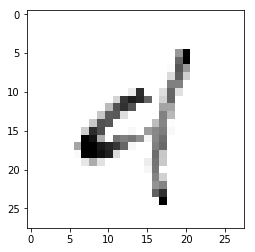

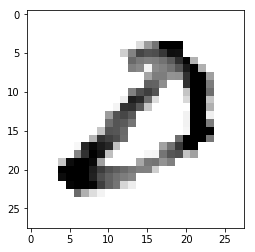

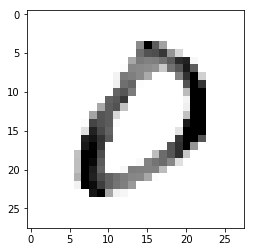

In [7]:
for i in np.random.choice(len(train_images), 3):
    plt.imshow(train_images[i], cmap="Greys", vmin=0, vmax=2)
    plt.show()

Lets define a helper function that fits, visualizes and stores trained models:

In [33]:
model_performance = []
def fit_and_save_model(name, model, X_train, y_train, X_validation, y_validation,
                       epochs = 5, batch_size=64, validation_split = 1.0/12, eval_batch_size=128):
    required_folders = './output/{}/logs/'.format(name)
    if not os.path.exists(required_folders):
        os.makedirs(required_folders)

    # Validation data is not shuffled! This is probably a problem!
    tensorboard = TensorBoard('./output/{}/logs/{}'.format(name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")))
    
    start_time = time.time()
    history = model.fit(X_train, to_categorical(y_train), 
                        validation_split=validation_split, 
                        epochs=epochs,
                        batch_size=batch_size, 
                        verbose=0, 
                        callbacks=[tensorboard])
    end_time = time.time()
    score = model.evaluate(X_validation, to_categorical(y_validation), verbose=0)
    
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    model_performance.append((name, score[0], score[1], end_time-start_time))
    
    with open("./output/{}/{}.score".format(name, name), 'w+') as f:
        f.write(summary)
        
    model.save('./output/{}/{}.h5'.format(name, name))
    with open("./output/{}/{}.json".format(name, name), 'w+') as f:
        f.write(model.to_json())
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model {}".format(name))
    
    plt.savefig('./output/{}/model_{}.png'.format(name,name))
    plt.show()

Now create and train a simple sequential model without any regularization:

Validation loss: 0.3048160768032074
Validation accuracy: 0.9122
Training time: 20.7311007976532


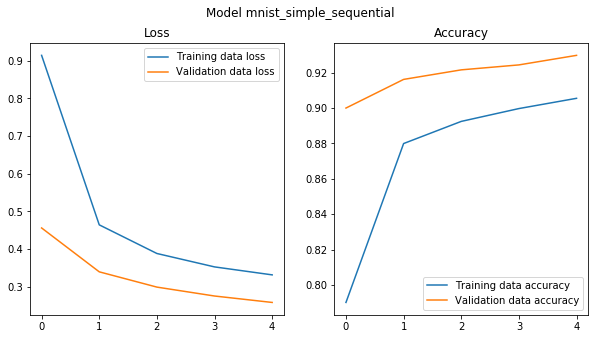

In [34]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28)))
simple_sequential.add(Dense(1000, activation='sigmoid'))
simple_sequential.add(Dense(10, activation='softmax'))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels)

Now lets try the same model with regularisation:

Validation loss: 2.0356258434295653
Validation accuracy: 0.9096
Training time: 25.13366413116455


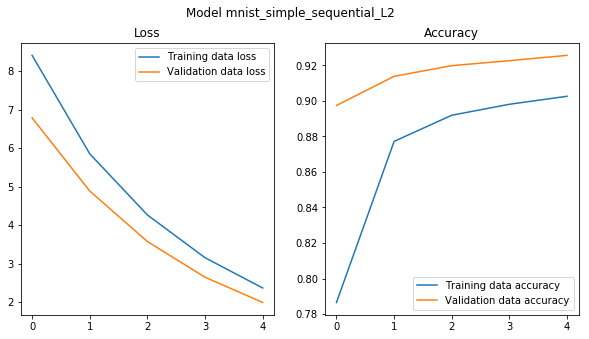

In [36]:
simple_sequential = Sequential()
simple_sequential.add(Flatten(input_shape=(28,28)))
simple_sequential.add(Dense(1000, activation='sigmoid', kernel_regularizer=l2(0.01)))
simple_sequential.add(Dense(10, activation='softmax'))
simple_sequential.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_simple_sequential_L2", simple_sequential, 
                   train_images, train_labels, validation_images, validation_labels)

Lets try a simple convolutional neural network:

Validation loss: 0.05732989951850614
Validation accuracy: 0.9852
Training time: 152.29964113235474


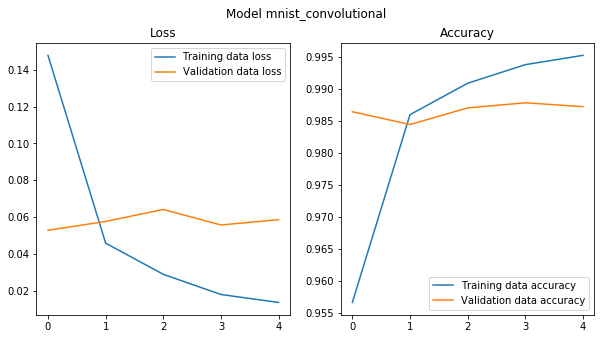

In [37]:
simple_convolutional = Sequential()
simple_convolutional.add(Reshape((28,28, 1), input_shape=(28,28)))
simple_convolutional.add(Conv2D(100, 
                 kernel_size=3, 
                 activation="relu"))
simple_convolutional.add(Dropout(rate=0.1))
simple_convolutional.add(Conv2D(100, 
                   kernel_size=3, 
                   activation='relu'))
simple_convolutional.add(Flatten())
simple_convolutional.add(Dense(10, activation='softmax'))
simple_convolutional.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
fit_and_save_model("mnist_convolutional", simple_convolutional,
                train_images, train_labels, validation_images, validation_labels,
                  epochs = 5, batch_size=128)

In [38]:
# Tasks: Experiment with different hyperparameter settings (e.g. learning rate, early stopping, batch sizes, etc)
# and observe their effects on training time, overfitting, and final accuracy.
# See if L2 regularisation has effect on network using relu activation function.
# Compare contrast with relu + dropout.

In [39]:
model_performance

[('mnist_simple_sequential', 0.3048160768032074, 0.9122, 20.7311007976532),
 ('mnist_simple_sequential_L2', 2.0356258434295653, 0.9096, 25.13366413116455),
 ('mnist_convolutional', 0.05732989951850614, 0.9852, 152.29964113235474)]